<a href="https://colab.research.google.com/github/sajawalgulniazi/Bearing_Fault_MFPT/blob/master/Simple_nn_RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
import os
import pandas as pd
import numpy as np
np.random.seed(1337)
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

Code so that the pandas only display 50 rows

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

### Importing the training test and target data

In [ ]:
train = pd.read_csv('train.txt', index_col= None, sep= ' ', header = None)
train.dropna(how='all', axis=1, inplace=True)
train.columns = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
test = pd.read_csv('test.txt', sep= " ", header = None)
test.dropna(how='all', axis=1, inplace=True)
test.columns = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
RUL = pd.read_csv('target.txt', sep=" ", header = None)
RUL.dropna(how='all', axis=1, inplace=True)
RUL.columns = ['RUL']

### Visulizing the raw training and test data and Remaining useful life

In [ ]:
train

,unit,cycles,op_setting1,op_setting2,op_setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.001,-0.000,100.000,518.670,641.820,1589.700,1400.600,14.620,...,521.660,2388.020,8138.620,8.419,0.030,392,2388,100.000,39.060,23.419
1,1,2,0.002,-0.000,100.000,518.670,642.150,1591.820,1403.140,14.620,...,522.280,2388.070,8131.490,8.432,0.030,392,2388,100.000,39.000,23.424
2,1,3,-0.004,0.000,100.000,518.670,642.350,1587.990,1404.200,14.620,...,522.420,2388.030,8133.230,8.418,0.030,390,2388,100.000,38.950,23.344
3,1,4,0.001,0.000,100.000,518.670,642.350,1582.790,1401.870,14.620,...,522.860,2388.080,8133.830,8.368,0.030,392,2388,100.000,38.880,23.374
4,1,5,-0.002,-0.000,100.000,518.670,642.370,1582.850,1406.220,14.620,...,522.190,2388.040,8133.800,8.429,0.030,393,2388,100.000,38.900,23.404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.000,-0.000,100.000,518.670,643.490,1597.980,1428.630,14.620,...,519.490,2388.260,8137.600,8.496,0.030,397,2388,100.000,38.490,22.974
20627,100,197,-0.002,-0.001,100.000,518.670,643.540,1604.500,1433.580,14.620,...,519.680,2388.220,8136.500,8.514,0.030,395,2388,100.000,38.300,23.159
20628,100,198,0.000,0.000,100.000,518.670,643.420,1602.460,1428.180,14.620,...,520.010,2388.240,8141.050,8.565,0.030,398,2388,100.000,38.440,22.933
20629,100,199,-0.001,0.000,100.000,518.670,643.230,1605.260,1426.530,14.620,...,519.670,2388.230,8139.290,8.539,0.030,395,2388,100.000,38.290,23.064


In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
unit,20631.000,51.507,29.228,1.000,26.000,52.000,77.000,100.000
cycles,20631.000,108.808,68.881,1.000,52.000,104.000,156.000,362.000
op_setting1,20631.000,-0.000,0.002,-0.009,-0.002,0.000,0.002,0.009
op_setting2,20631.000,0.000,0.000,-0.001,-0.000,0.000,0.000,0.001
op_setting3,20631.000,100.000,0.000,100.000,100.000,100.000,100.000,100.000
s1,20631.000,518.670,0.000,518.670,518.670,518.670,518.670,518.670
s2,20631.000,642.681,0.500,641.210,642.325,642.640,643.000,644.530
s3,20631.000,1590.523,6.131,1571.040,1586.260,1590.100,1594.380,1616.910
s4,20631.000,1408.934,9.001,1382.250,1402.360,1408.040,1414.555,1441.490
s5,20631.000,14.620,0.000,14.620,14.620,14.620,14.620,14.620


### removing the variables which doesnt change throughout the length of the signal 

In [ ]:
train.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)

In [ ]:
test

,unit,cycles,op_setting1,op_setting2,op_setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.002,0.000,100.000,518.670,643.020,1585.290,1398.210,14.620,...,521.720,2388.030,8125.550,8.405,0.030,392,2388,100.000,38.860,23.373
1,1,2,-0.003,-0.000,100.000,518.670,641.710,1588.450,1395.420,14.620,...,522.160,2388.060,8139.620,8.380,0.030,393,2388,100.000,39.020,23.392
2,1,3,0.000,0.000,100.000,518.670,642.460,1586.940,1401.340,14.620,...,521.970,2388.030,8130.100,8.444,0.030,393,2388,100.000,39.080,23.417
3,1,4,0.004,0.000,100.000,518.670,642.440,1584.120,1406.420,14.620,...,521.380,2388.050,8132.900,8.392,0.030,391,2388,100.000,39.000,23.374
4,1,5,0.001,0.000,100.000,518.670,642.510,1587.190,1401.920,14.620,...,522.150,2388.030,8129.540,8.403,0.030,390,2388,100.000,38.990,23.413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.005,0.000,100.000,518.670,643.240,1599.450,1415.790,14.620,...,520.690,2388.000,8213.280,8.472,0.030,394,2388,100.000,38.650,23.197
13092,100,195,-0.001,-0.000,100.000,518.670,643.220,1595.690,1422.050,14.620,...,521.050,2388.090,8210.850,8.451,0.030,395,2388,100.000,38.570,23.277
13093,100,196,-0.001,-0.000,100.000,518.670,643.440,1593.150,1406.820,14.620,...,521.180,2388.040,8217.240,8.457,0.030,395,2388,100.000,38.620,23.205
13094,100,197,-0.004,0.000,100.000,518.670,643.260,1594.990,1419.360,14.620,...,521.330,2388.080,8220.480,8.471,0.030,395,2388,100.000,38.660,23.270


In [ ]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
unit,13096.000,51.544,28.289,1.000,28.000,52.000,76.000,100.000
cycles,13096.000,76.837,53.058,1.000,33.000,69.000,113.000,303.000
op_setting1,13096.000,-0.000,0.002,-0.008,-0.002,0.000,0.002,0.008
op_setting2,13096.000,0.000,0.000,-0.001,-0.000,0.000,0.000,0.001
op_setting3,13096.000,100.000,0.000,100.000,100.000,100.000,100.000,100.000
s1,13096.000,518.670,0.000,518.670,518.670,518.670,518.670,518.670
s2,13096.000,642.475,0.401,641.130,642.197,642.460,642.740,644.300
s3,13096.000,1588.099,5.003,1569.040,1584.600,1587.990,1591.362,1607.550
s4,13096.000,1404.735,6.688,1384.390,1399.950,1404.440,1409.050,1433.360
s5,13096.000,14.620,0.000,14.620,14.620,14.620,14.620,14.620


In [ ]:
# Similar variables based on the training data
test.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)

In [ ]:
RUL

,RUL
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [ ]:
RUL['RUL'].describe()

count   100.000
mean     75.520
std      41.765
min       7.000
25%      32.750
50%      86.000
75%     112.250
max     145.000
Name: RUL, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


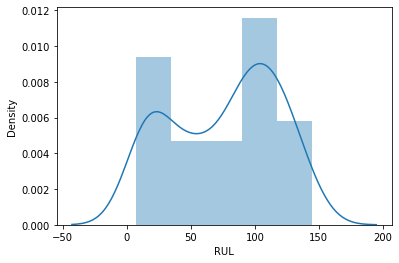

In [ ]:
# remaining useful life density plot
sns.distplot(RUL['RUL'],kde=True)

### Represent the training and testing data graphically

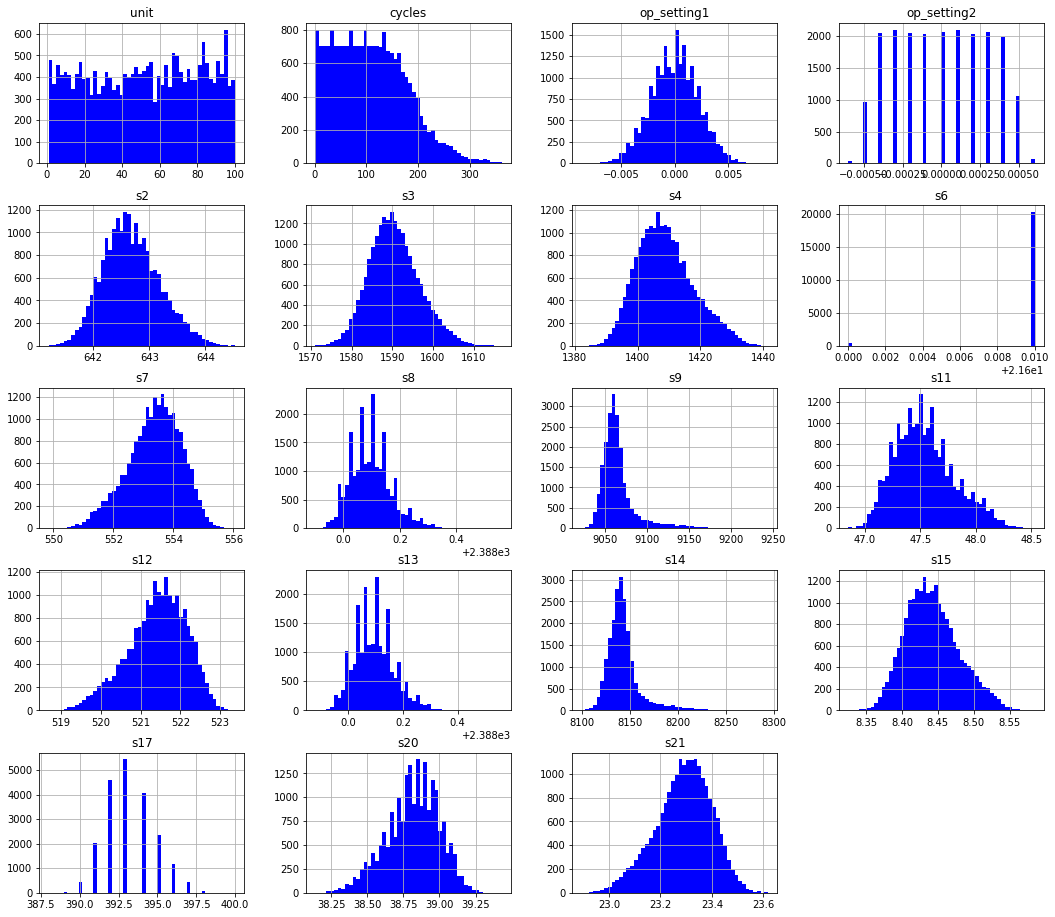

In [ ]:
train.hist(bins=50, figsize=(18,16), color="blue")
plt.show()

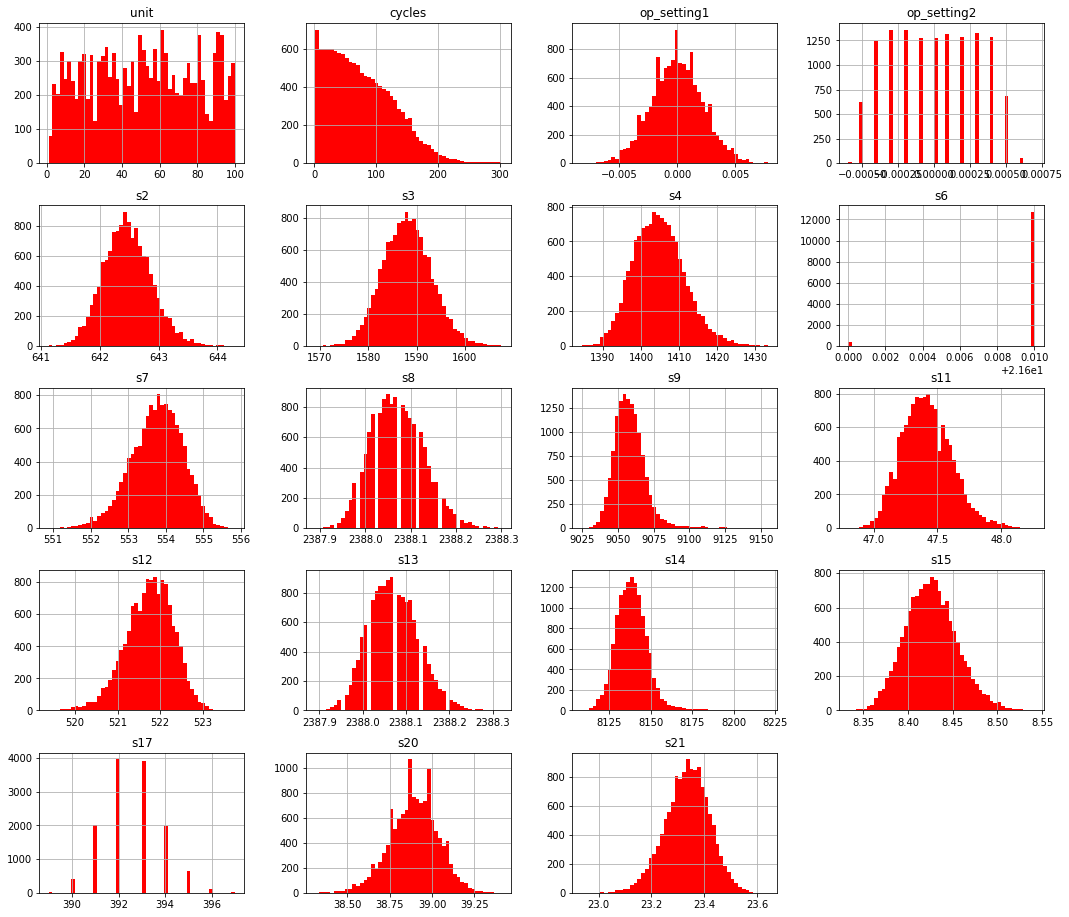

In [ ]:
test.hist(bins=50, figsize=(18,16), color="red")
plt.show()

Grouping the number of cycles run by each engine for the training data colums units and maximum from the cycles value for the respecting engine

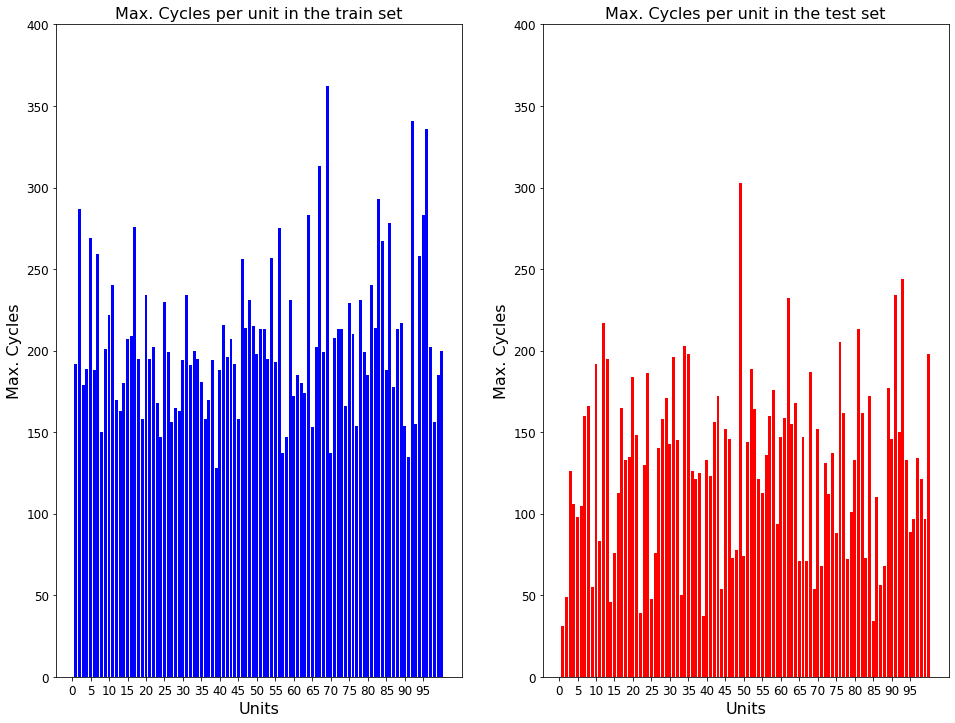

In [ ]:
cyclestrain = train.groupby('unit', as_index=False)['cycles'].max()
cyclestest = test.groupby('unit', as_index=False)['cycles'].max()

# Plotting the data 
fig = plt.figure(figsize = (16,12))

# Plot for training 
fig.add_subplot(1,2,1)
bar_labels = list(cyclestrain['unit'])
bars = plt.bar(list(cyclestrain['unit']), cyclestrain['cycles'], color='blue')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max. Cycles', fontsize=16)
plt.title('Max. Cycles per unit in the train set', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)

#Plot for test
fig.add_subplot(1,2,2)
bars = plt.bar(list(cyclestest['unit']), cyclestest['cycles'], color='red')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max. Cycles', fontsize=16)
plt.title('Max. Cycles per unit in the test set', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Plotting the signal for the sensor and other variables for furture understanding only for unit 1 over the different cycles

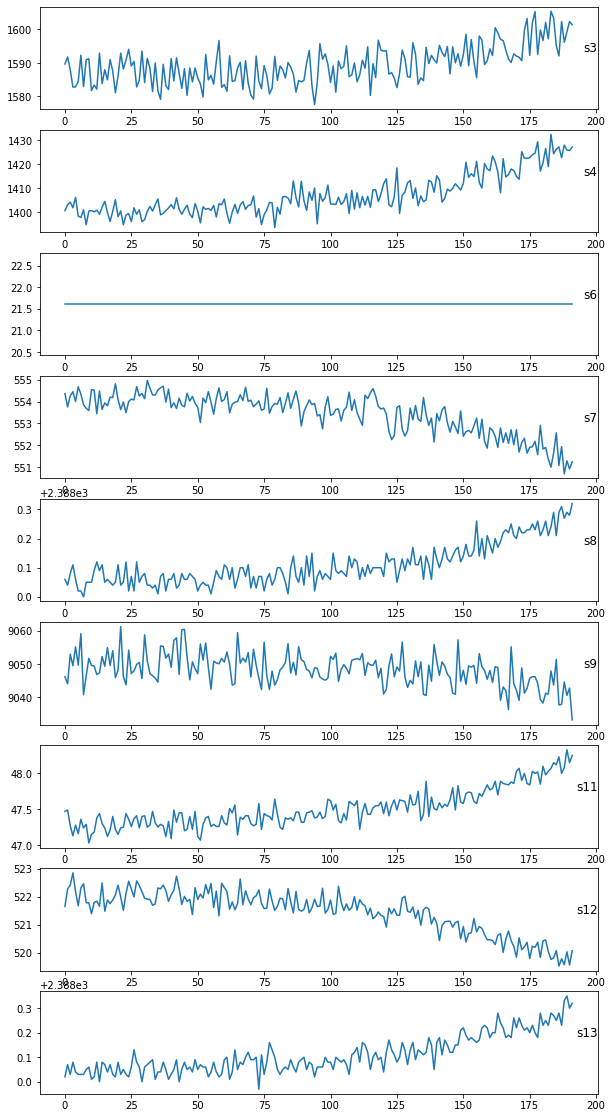

In [ ]:
values = train[train.unit==1].values
groups = [5, 6, 7, 8, 9, 10, 11,12,13]
i = 1
plt.figure(figsize=(10,20))
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(train.columns[group], y=0.5, loc='right')
 i += 1
plt.show()

observing how s7 variable behaves over number of cycles 
some variables show a decresign trend and some variables show an increasing trend like temperature

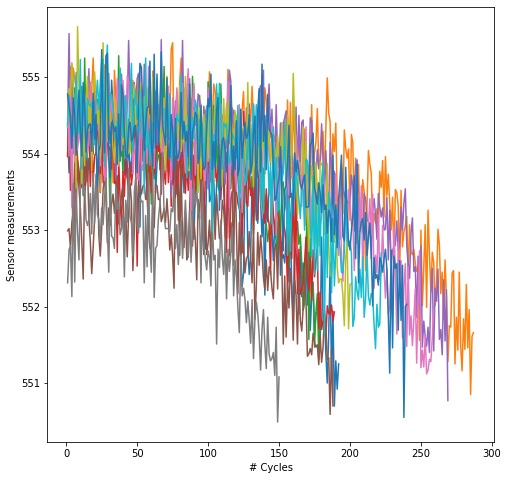

In [ ]:
plt.figure(figsize = (8, 8))
plt.plot(train[train.unit==1].cycles, train[train.unit==1].s7)
plt.plot(train[train.unit==2].cycles, train[train.unit==2].s7)
plt.plot(train[train.unit==3].cycles, train[train.unit==3].s7)
plt.plot(train[train.unit==4].cycles, train[train.unit==4].s7)
plt.plot(train[train.unit==5].cycles, train[train.unit==5].s7)
plt.plot(train[train.unit==6].cycles, train[train.unit==6].s7)
plt.plot(train[train.unit==7].cycles, train[train.unit==7].s7)
plt.plot(train[train.unit==8].cycles, train[train.unit==8].s7)
plt.plot(train[train.unit==9].cycles, train[train.unit==9].s7)
plt.plot(train[train.unit==10].cycles, train[train.unit==10].s7)
plt.plot(train[train.unit==11].cycles, train[train.unit==11].s7)
plt.xlabel('# Cycles')
plt.ylabel('Sensor measurements')
plt.show()

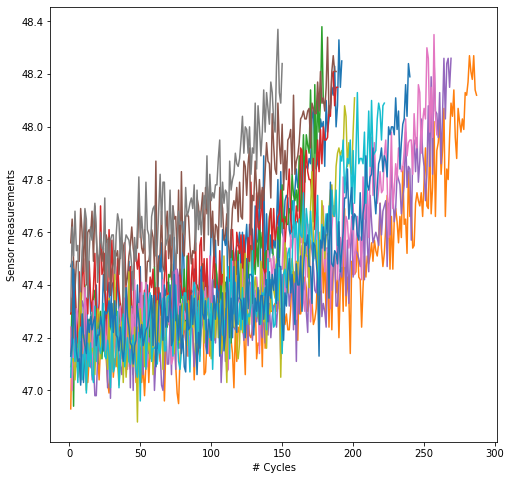

In [ ]:
# Similar plot for variable s11
plt.figure(figsize = (8, 8))
plt.plot(train[train.unit==1].cycles, train[train.unit==1].s11)
plt.plot(train[train.unit==2].cycles, train[train.unit==2].s11)
plt.plot(train[train.unit==3].cycles, train[train.unit==3].s11)
plt.plot(train[train.unit==4].cycles, train[train.unit==4].s11)
plt.plot(train[train.unit==5].cycles, train[train.unit==5].s11)
plt.plot(train[train.unit==6].cycles, train[train.unit==6].s11)
plt.plot(train[train.unit==7].cycles, train[train.unit==7].s11)
plt.plot(train[train.unit==8].cycles, train[train.unit==8].s11)
plt.plot(train[train.unit==9].cycles, train[train.unit==9].s11)
plt.plot(train[train.unit==10].cycles, train[train.unit==10].s11)
plt.plot(train[train.unit==11].cycles, train[train.unit==11].s11)
plt.xlabel('# Cycles')
plt.ylabel('Sensor measurements')
plt.show()

Grouping the minimum and maximum number of each variable for the first 10 units for data visulization

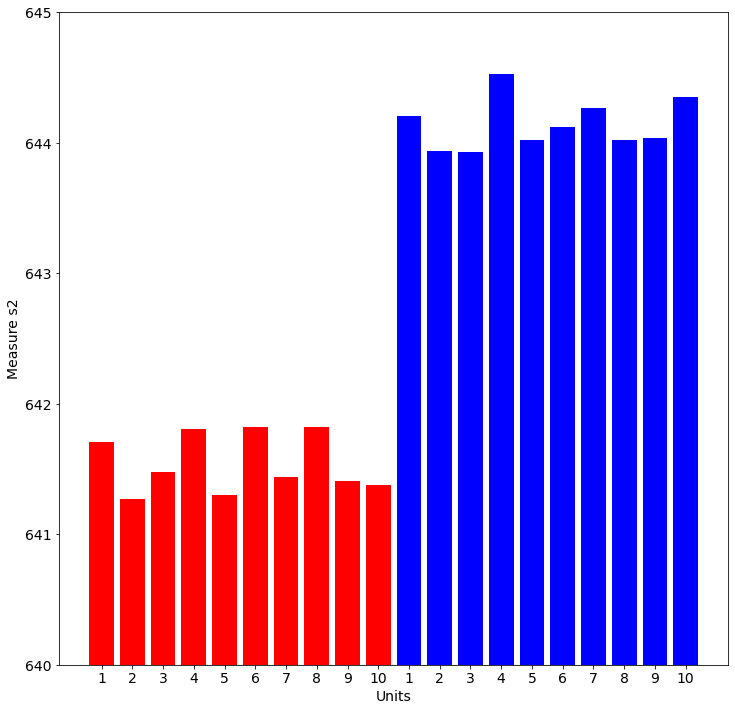

In [ ]:
minb = train.groupby('unit', as_index=False).min().head(10)
maxb = train.groupby('unit', as_index=False).max().head(10)
# Combining for plotting
mmtable = minb.append(maxb, ignore_index=True)
plt.figure(figsize = (12,12))
col = np.concatenate((np.repeat('red', 10), np.repeat('blue', 10)), axis=0)
bar_labels = list(mmtable['unit'])
x_pos = list(range(len(bar_labels)))
# For s2 column
bars = plt.bar(x_pos, mmtable['s2'], color=col)
# Range for better observation
plt.ylim([640, 645])
plt.xlabel('Units', fontsize=14)
plt.ylabel('Measure s2', fontsize=14)
plt.xticks(x_pos, bar_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

adding a column in the train data for max cycles for each unit

In [ ]:
train = pd.merge(train, train.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
train.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)

In [ ]:
train

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,maxcycles
0,1,1,-0.001,-0.000,641.820,1589.700,1400.600,21.610,554.360,2388.060,9046.190,47.470,521.660,2388.020,8138.620,8.419,392,39.060,23.419,192
1,1,2,0.002,-0.000,642.150,1591.820,1403.140,21.610,553.750,2388.040,9044.070,47.490,522.280,2388.070,8131.490,8.432,392,39.000,23.424,192
2,1,3,-0.004,0.000,642.350,1587.990,1404.200,21.610,554.260,2388.080,9052.940,47.270,522.420,2388.030,8133.230,8.418,390,38.950,23.344,192
3,1,4,0.001,0.000,642.350,1582.790,1401.870,21.610,554.450,2388.110,9049.480,47.130,522.860,2388.080,8133.830,8.368,392,38.880,23.374,192
4,1,5,-0.002,-0.000,642.370,1582.850,1406.220,21.610,554.000,2388.060,9055.150,47.280,522.190,2388.040,8133.800,8.429,393,38.900,23.404,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.000,-0.000,643.490,1597.980,1428.630,21.610,551.430,2388.190,9065.520,48.070,519.490,2388.260,8137.600,8.496,397,38.490,22.974,200
20627,100,197,-0.002,-0.001,643.540,1604.500,1433.580,21.610,550.860,2388.230,9065.110,48.040,519.680,2388.220,8136.500,8.514,395,38.300,23.159,200
20628,100,198,0.000,0.000,643.420,1602.460,1428.180,21.610,550.940,2388.240,9065.900,48.090,520.010,2388.240,8141.050,8.565,398,38.440,22.933,200
20629,100,199,-0.001,0.000,643.230,1605.260,1426.530,21.610,550.680,2388.250,9073.720,48.390,519.670,2388.230,8139.290,8.539,395,38.290,23.064,200


Adding column for the time to failure which is max cycles - the original cycles at that time

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


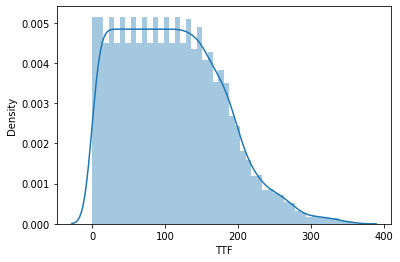

In [ ]:
train['TTF'] = train['maxcycles'] - train['cycles']
sns.distplot(train['TTF'],kde=True)

#Scalling

In [ ]:
scaler = MinMaxScaler()

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
unit,20631.000,51.507,29.228,1.000,26.000,52.000,77.000,100.000
cycles,20631.000,108.808,68.881,1.000,52.000,104.000,156.000,362.000
op_setting1,20631.000,-0.000,0.002,-0.009,-0.002,0.000,0.002,0.009
op_setting2,20631.000,0.000,0.000,-0.001,-0.000,0.000,0.000,0.001
s2,20631.000,642.681,0.500,641.210,642.325,642.640,643.000,644.530
s3,20631.000,1590.523,6.131,1571.040,1586.260,1590.100,1594.380,1616.910
s4,20631.000,1408.934,9.001,1382.250,1402.360,1408.040,1414.555,1441.490
s6,20631.000,21.610,0.001,21.600,21.610,21.610,21.610,21.610
s7,20631.000,553.368,0.885,549.850,552.810,553.440,554.010,556.060
s8,20631.000,2388.097,0.071,2387.900,2388.050,2388.090,2388.140,2388.560


Copying data

In [ ]:
ntrain = train.copy()

Then scaling the data that we need to scale

In [ ]:
ntrain.iloc[:,2:19] = scaler.fit_transform(ntrain.iloc[:,2:19])

Visulizing the scaled data

In [ ]:
ntrain.describe().T

,count,mean,std,min,25%,50%,75%,max
unit,20631.000,51.507,29.228,1.000,26.000,52.000,77.000,100.000
cycles,20631.000,108.808,68.881,1.000,52.000,104.000,156.000,362.000
op_setting1,20631.000,0.499,0.126,0.000,0.414,0.500,0.586,1.000
op_setting2,20631.000,0.502,0.244,0.000,0.333,0.500,0.750,1.000
s2,20631.000,0.443,0.151,0.000,0.336,0.431,0.539,1.000
s3,20631.000,0.425,0.134,0.000,0.332,0.416,0.509,1.000
s4,20631.000,0.450,0.152,0.000,0.339,0.435,0.545,1.000
s6,20631.000,0.980,0.139,0.000,1.000,1.000,1.000,1.000
s7,20631.000,0.566,0.143,0.000,0.477,0.578,0.670,1.000
s8,20631.000,0.298,0.108,0.000,0.227,0.288,0.364,1.000


Similar process with the test data but the scale is used from the training data

In [ ]:
ntest = test.copy()
ntest.iloc[:,2:19] = scaler.transform(ntest.iloc[:,2:19])
ntest.describe().T

,count,mean,std,min,25%,50%,75%,max
unit,13096.000,51.544,28.289,1.000,28.000,52.000,76.000,100.000
cycles,13096.000,76.837,53.058,1.000,33.000,69.000,113.000,303.000
op_setting1,13096.000,0.499,0.127,0.029,0.414,0.500,0.586,0.948
op_setting2,13096.000,0.504,0.245,0.000,0.333,0.500,0.750,1.083
s2,13096.000,0.381,0.121,-0.024,0.297,0.377,0.461,0.931
s3,13096.000,0.372,0.109,-0.044,0.296,0.370,0.443,0.796
s4,13096.000,0.380,0.113,0.036,0.299,0.375,0.452,0.863
s6,13096.000,0.970,0.170,0.000,1.000,1.000,1.000,1.000
s7,13096.000,0.629,0.110,0.166,0.557,0.636,0.707,0.965
s8,13096.000,0.259,0.087,-0.015,0.197,0.258,0.318,0.606


The values in the test dataset are not exactly the same as 1 and 0 because it is scaled according to the training dataset
- and the units and cycles doesnt need to be scaled

#Visualizing the scaled data

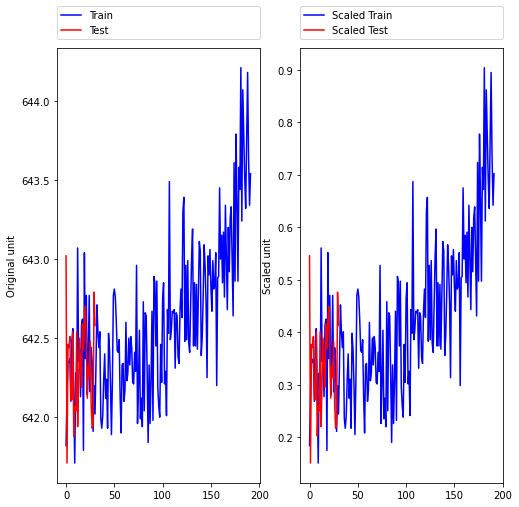

In [ ]:
fig = plt.figure(figsize = (8, 8))

fig.add_subplot(1,2,1)
plt.plot(train[train.unit==1].s2, color='blue')
plt.plot(test[test.unit==1].s2, color='red')
plt.legend(['Train','Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode='expand', borderaxespad=0)
plt.ylabel('Original unit')

fig.add_subplot(1,2,2)
plt.plot(ntrain[ntrain.unit==1].s2, color='blue')
plt.plot(ntest[ntest.unit==1].s2, color='red')
plt.legend(['Scaled Train','Scaled Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode='expand', borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

## Calculating the fractional time to failure for comparizon amoung units 

In [ ]:
def fractionTTF(dat,q):
 return(dat.TTF[q]-dat.TTF.min()) / float(dat.TTF.max()-dat.TTF.min())

In [ ]:
fTTFz = []
fTTF = []
for i in range(train['unit'].min(),train['unit'].max()+1):
 dat=train[train.unit==i]
 dat = dat.reset_index(drop=True)
 for q in range(len(dat)):
  fTTFz = fractionTTF(dat, q)
  fTTF.append(fTTFz)

Adding the fraction time to failure column to the ntraining dataset

In [ ]:
ntrain['fTTF'] = fTTF

Visualizing the difference between the fractional and original time to failure in the training dataset

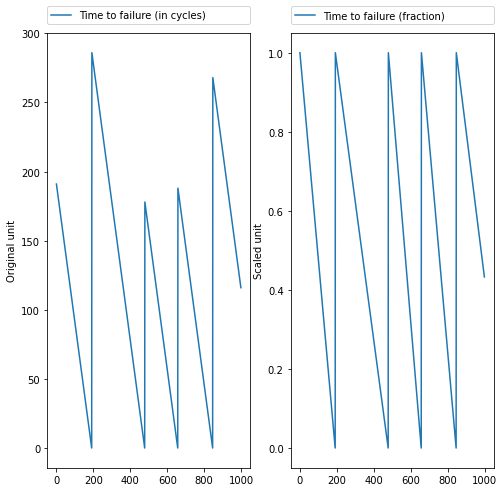

In [ ]:
mx = 1000
fig = plt.figure(figsize = (8, 8))
fig.add_subplot(1,2,1)
plt.plot(ntrain.TTF[0:mx])
plt.legend(['Time to failure (in cycles)'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Original unit')
fig.add_subplot(1,2,2)
plt.plot(ntrain.fTTF[0:mx])
plt.legend(['Time to failure (fraction)'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

In [ ]:
pd.DataFrame(ntrain.columns).T

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,maxcycles,TTF,fTTF


Training dataset

In [ ]:
X_train = ntrain.values[:,1:19]
X_train

array([[1.00000000e+00, 4.59770115e-01, 1.66666667e-01, ...,
        3.33333333e-01, 7.13178295e-01, 7.24661696e-01],
       [2.00000000e+00, 6.09195402e-01, 2.50000000e-01, ...,
        3.33333333e-01, 6.66666667e-01, 7.31013532e-01],
       [3.00000000e+00, 2.52873563e-01, 7.50000000e-01, ...,
        1.66666667e-01, 6.27906977e-01, 6.21375311e-01],
       ...,
       [1.98000000e+02, 5.22988506e-01, 5.00000000e-01, ...,
        8.33333333e-01, 2.32558140e-01, 5.39906103e-02],
       [1.99000000e+02, 4.36781609e-01, 7.50000000e-01, ...,
        5.83333333e-01, 1.16279070e-01, 2.34465617e-01],
       [2.00000000e+02, 3.16091954e-01, 8.33333333e-02, ...,
        6.66666667e-01, 1.78294574e-01, 2.18171776e-01]])

In [ ]:
X_train.shape

(20631, 18)

In [ ]:
y_train = ntrain.values[:, 21]
y_train, y_train.shape

(array([1.        , 0.9947644 , 0.9895288 , ..., 0.01005025, 0.00502513,
        0.        ]), (20631,))

Testing dataset

In [ ]:
X_test = ntest.values[:,1:19]
X_test, X_test.shape

(array([[  1.        ,   0.63218391,   0.75      , ...,   0.33333333,
           0.55813953,   0.66183375],
        [  2.        ,   0.34482759,   0.25      , ...,   0.41666667,
           0.68217054,   0.68682684],
        [  3.        ,   0.51724138,   0.58333333, ...,   0.41666667,
           0.72868217,   0.72134769],
        ...,
        [196.        ,   0.46551724,   0.25      , ...,   0.58333333,
           0.37209302,   0.4293013 ],
        [197.        ,   0.2816092 ,   0.58333333, ...,   0.58333333,
           0.40310078,   0.51877934],
        [198.        ,   0.57471264,   0.75      , ...,   0.66666667,
           0.43410853,   0.40223695]]), (13096, 18))

# Using the neural network to pridict the remaining useful life of the CMAPPS data

In [ ]:
import tensorflow as tf

In [ ]:
# Creat a model
model1 = tf.keras.Sequential([
                              tf.keras.layers.Dense(200, activation='relu'),
                              tf.keras.layers.Dense(100, activation='relu'),
                              tf.keras.layers.Dense(10, activation='relu'),
                              tf.keras.layers.Dense(1)
])

# Compile the model

model1.compile(loss=tf.keras.losses.MeanSquaredError(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['mse'])

# fit the model
model1.fit(X_train, y_train, epochs=100)

Epoch 1/100
645/645 [==============================] - 3s 2ms/step - loss: 0.2062 - mse: 0.2062
Epoch 2/100
645/645 [==============================] - 2s 3ms/step - loss: 0.0287 - mse: 0.0287
Epoch 3/100
645/645 [==============================] - 1s 2ms/step - loss: 0.0460 - mse: 0.0460
Epoch 4/100
645/645 [==============================] - 2s 2ms/step - loss: 0.0108 - mse: 0.0108
Epoch 5/100
645/645 [==============================] - 1s 2ms/step - loss: 0.0098 - mse: 0.0098
Epoch 6/100
645/645 [==============================] - 2s 2ms/step - loss: 0.0078 - mse: 0.0078
Epoch 7/100
645/645 [==============================] - 2s 2ms/step - loss: 0.0097 - mse: 0.0097
Epoch 8/100
645/645 [==============================] - 2s 2ms/step - loss: 0.0148 - mse: 0.0148
Epoch 9/100
645/645 [==============================] - 2s 2ms/step - loss: 0.0149 - mse: 0.0149
Epoch 10/100
645/645 [==============================] - 2s 2ms/step - loss: 0.0071 - mse: 0.0071
Epoch 11/100
645/645 [=================

In [ ]:
X_test

array([[  1.        ,   0.63218391,   0.75      , ...,   0.33333333,
          0.55813953,   0.66183375],
       [  2.        ,   0.34482759,   0.25      , ...,   0.41666667,
          0.68217054,   0.68682684],
       [  3.        ,   0.51724138,   0.58333333, ...,   0.41666667,
          0.72868217,   0.72134769],
       ...,
       [196.        ,   0.46551724,   0.25      , ...,   0.58333333,
          0.37209302,   0.4293013 ],
       [197.        ,   0.2816092 ,   0.58333333, ...,   0.58333333,
          0.40310078,   0.51877934],
       [198.        ,   0.57471264,   0.75      , ...,   0.66666667,
          0.43410853,   0.40223695]])

In [ ]:
score = model1.predict(X_test)

In [ ]:
score[0:10]

array([[0.9686996 ],
       [0.96667683],
       [0.96123517],
       [0.9552293 ],
       [0.953583  ],
       [0.9472201 ],
       [0.94230497],
       [0.9375802 ],
       [0.93594706],
       [0.92904484]], dtype=float32)

In [ ]:
print(score.min(), score.max())

0.013981193 0.9925996


In [ ]:
test = pd.merge(test, test.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
test.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)

In [ ]:
test['score'] = score 

In [ ]:
test

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s11,s12,s13,s14,s15,s17,s20,s21,maxcycles,score
0,1,1,0.002,0.000,643.020,1585.290,1398.210,21.610,553.900,2388.040,...,47.200,521.720,2388.030,8125.550,8.405,392,38.860,23.373,31,0.969
1,1,2,-0.003,-0.000,641.710,1588.450,1395.420,21.610,554.850,2388.010,...,47.500,522.160,2388.060,8139.620,8.380,393,39.020,23.392,31,0.967
2,1,3,0.000,0.000,642.460,1586.940,1401.340,21.610,554.110,2388.050,...,47.500,521.970,2388.030,8130.100,8.444,393,39.080,23.417,31,0.961
3,1,4,0.004,0.000,642.440,1584.120,1406.420,21.610,554.070,2388.030,...,47.280,521.380,2388.050,8132.900,8.392,391,39.000,23.374,31,0.955
4,1,5,0.001,0.000,642.510,1587.190,1401.920,21.610,554.160,2388.010,...,47.310,522.150,2388.030,8129.540,8.403,390,38.990,23.413,31,0.954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.005,0.000,643.240,1599.450,1415.790,21.610,553.410,2388.020,...,47.690,520.690,2388.000,8213.280,8.472,394,38.650,23.197,198,0.075
13092,100,195,-0.001,-0.000,643.220,1595.690,1422.050,21.610,553.220,2388.050,...,47.600,521.050,2388.090,8210.850,8.451,395,38.570,23.277,198,0.077
13093,100,196,-0.001,-0.000,643.440,1593.150,1406.820,21.610,553.040,2388.110,...,47.570,521.180,2388.040,8217.240,8.457,395,38.620,23.205,198,0.075
13094,100,197,-0.004,0.000,643.260,1594.990,1419.360,21.610,553.370,2388.070,...,47.610,521.330,2388.080,8220.480,8.471,395,38.660,23.270,198,0.069


In [ ]:
def totcycles(data):
 return(data['cycles'] / (1-data['score']))
 
test['maxpredcycles'] = totcycles(test)

In [ ]:
def RULfunction(data):
 return(data['maxpredcycles']-data['maxcycles'])
test['RUL'] = RULfunction(test)

In [ ]:
test['RUL'].head()

0    0.948
1   29.018
2   46.390
3   58.344
4   76.719
Name: RUL, dtype: float64

# Evaluation 

In [ ]:
t = test.columns == 'RUL'
ind = [i for i, x in enumerate(t) if x]
predictedRUL = []
for i in range(test.unit.min(), test.unit.max()+1):
 npredictedRUL=test[test.unit==i].iloc[test[test.unit==i].cycles.max()-1,ind]
 predictedRUL.append(npredictedRUL)

In [ ]:
xtrueRUL = list(RUL['RUL'])
otrueRUL = []
for i in range(0,len(xtrueRUL)):
 otrueRUL = np.concatenate((otrueRUL,
 list(reversed(np.arange(int(xtrueRUL[i]))))))
 xpredictedRUL = list(round(x) for x in predictedRUL)
opredictedRUL = []
for i in range(0,len(xpredictedRUL)):
    opredictedRUL = np.concatenate((opredictedRUL,
                                    list(reversed(np.arange(xpredictedRUL[i].item())))))
    xpredictedRUL1= []
for i in range(0,len(xpredictedRUL)):
    xpredictedRUL1.append(int(xpredictedRUL[i]))  
xpredictedRUL2 = np.array(xpredictedRUL1)
xpredictedRUL2 = np.array(xpredictedRUL1)

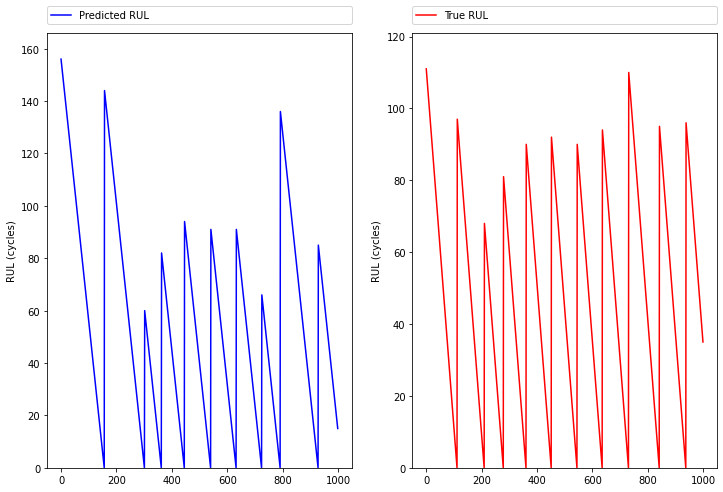

In [ ]:
mx = 1000
fig = plt.figure(figsize = (12, 8))
fig.add_subplot(1,2,1)
plt.plot(opredictedRUL[0:mx], color='blue')
plt.legend(['Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102),
 loc=3, mode='expand', borderaxespad=0)
plt.ylim(0, opredictedRUL[0:mx].max()+10)
plt.ylabel('RUL (cycles)')
fig.add_subplot(1,2,2)
plt.plot(otrueRUL[0:mx], color='red')
plt.legend(['True RUL'], bbox_to_anchor=(0., 1.02, 1., .102),
 loc=3, mode='expand', borderaxespad=0)
plt.ylabel('RUL (cycles)')
plt.ylim(0,otrueRUL[0:mx].max()+10)
plt.show()

# Comparison Predicted and True RUL

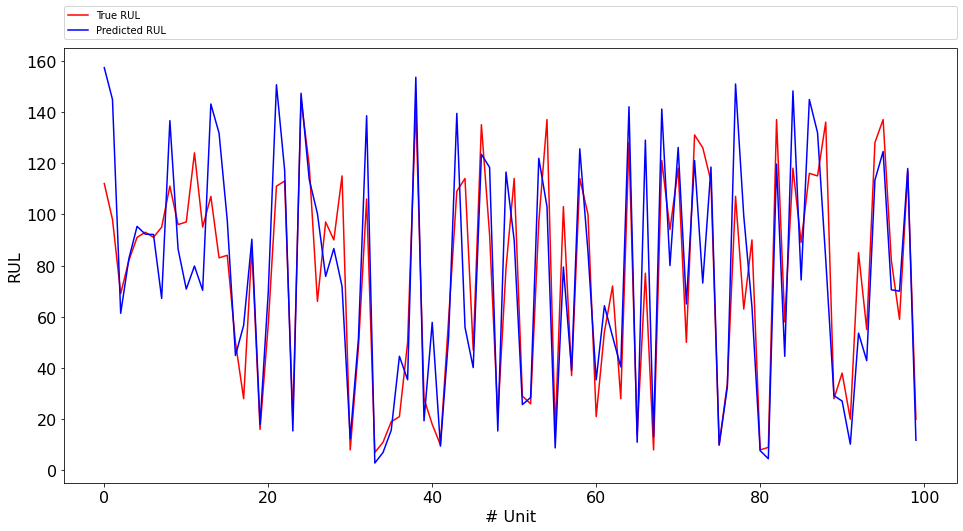

In [ ]:
plt.figure(figsize = (16, 8))
plt.plot(RUL, color='red')
plt.plot(predictedRUL, color='blue')
plt.xlabel('# Unit', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('RUL', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['True RUL','Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102),
 loc=3, mode='expand', borderaxespad=0)
plt.show()

In [ ]:
df1 = pd.concat([pd.Series(RUL['RUL']), pd.Series(xpredictedRUL2)], axis=1)
df1.columns = ['true', 'predicted']

In [ ]:
df1['diff'] = df1['predicted']-df1['true']
df1.head()

,true,predicted,diff
0,112,157,45
1,98,145,47
2,69,61,-8
3,82,83,1
4,91,95,4


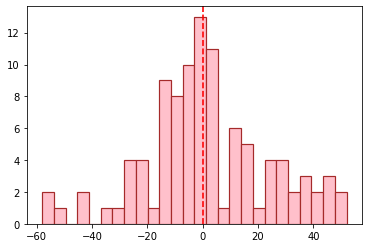

In [ ]:
plt.hist(df1['diff'], bins=26, color='pink', edgecolor='brown', linewidth=1.2)
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.6)
plt.show()

In [ ]:
pd.DataFrame({'Count': [(df1['diff']<0).sum(), (df1['diff']==0).sum(),
 (df1['diff']>0).sum()]}, columns=['Count'],
 index=['Smaller', 'Zero', 'Larger'])

,Count
Smaller,50
Zero,2
Larger,48


# the value of remaining useful life is a little over estimated

##Regression Metrics

In [ ]:
# compute the R Square for model 
from sklearn import metrics
print("R-squared", "{:.2%}".format(metrics.r2_score(RUL, xpredictedRUL)))

R-squared 69.85%


In [ ]:
# compute the RMSE of our predictions

print("The Root Mean Squared Error (RMSE) is:",
 round(np.sqrt(metrics.mean_squared_error(RUL, xpredictedRUL)),2))
print("The Mean Absolute Error (MAE) is:",
 round(metrics.mean_absolute_error(RUL, xpredictedRUL),2))

The Root Mean Squared Error (RMSE) is: 22.82
The Mean Absolute Error (MAE) is: 17.2


##Feature Importance

In [ ]:
#feature_labels = np.array(['unit', 'cycles', 'op_setting1', 'op_setting2', 's2', 's3', 's4', 's6',
# 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20',
# 's21', 'maxcycles', 'score', 'maxpredcycles'])
#importance = regressor.feature_importances_
#feature_indexes_by_importance = importance.argsort()[::-1]
#for index in feature_indexes_by_importance:
# print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

In [ ]:
import pickle

model = regressor